In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

dataframe = genfromtxt('train.csv', delimiter=',', skip_header=True)


In [2]:
y, X = dataframe[:,0], dataframe[:, 1:]
y = y.reshape([-1,1])

In [3]:
# Shuffle data set
indices = np.array(range(len(X)))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

X_train -= 127
X_train /= 127

X_test -= 127
X_test /= 127

In [4]:
X_test.shape
y.shape

(42000, 1)

In [5]:
import tensorflow as tf

def dense(input_size, output_size, mean=0.0, stddev=0.01, dtype=tf.float32, activation_type=None):
    weight_tensor = tf.Variable(tf.random_normal(shape=(input_size, output_size),
                                                mean=mean, stddev=stddev, dtype=dtype))
    
    bias_tensor = tf.Variable(tf.zeros(output_size))
    
    def apply_dense(X, keep_prob):
        result = tf.add(tf.matmul(X, weight_tensor), bias_tensor)
        return tf.layers.dropout(activation_type(result), rate=1-keep_prob, training=True) if activation_type != None else result

    return apply_dense
        

/home/safwan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
def combine(tensor_one, tensor_two):
    return tf.div(tf.add(tensor_one, tensor_two), 2)

In [7]:
input_ = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1]))
labels = tf.placeholder(dtype=tf.int32, shape=(None, 1))
learning_rate_ph = tf.placeholder(dtype=tf.float32)
keep_prob = tf.placeholder(dtype=tf.float32)

In [8]:
def nn():
    
    l1 = dense(int(input_.shape[1]), 700, activation_type=tf.nn.relu)(input_, keep_prob)
    l2 = dense(int(l1.shape[1]), 400, activation_type=tf.nn.relu)(l1, keep_prob)
    l3 = dense(int(l2.shape[1]), 64, activation_type=tf.nn.relu)(l2, keep_prob)
    
    #l4 = combine(l1, l3)
    l5 = dense(int(l3.shape[1]), 32, activation_type=tf.nn.relu)(l3, keep_prob)
    
    l6 = dense(int(l5.shape[1]), 64, activation_type=tf.nn.relu)(l5, keep_prob)
    
    #l7 = combine(l2,l6)
    
    l8 = dense(int(l6.shape[1]), 64, activation_type=tf.nn.relu)(l6, keep_prob)
    l9 = dense(int(l8.shape[1]), 64, activation_type=tf.nn.relu)(l8, keep_prob)
    
    #l10 = combine(l8,l9)
    
    out = dense(int(l3.shape[1]), 10)(l3, keep_prob)
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=tf.one_hot(labels,depth=10)))
    
    # Apply an optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    
    return cost, optimizer, out

In [9]:
def get_next_batch(batch_size, X, y):
    for i in range(int(y.shape[0]/batch_size)-1):
        yield X[i: i+batch_size, :] , y[i: i+batch_size]

In [10]:
cost, optimizer, output = nn()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [26]:
from sklearn.metrics import accuracy_score

# Initialize tensorflow session
init = tf.global_variables_initializer()

epochs = 1500
batch_size = 100
num_batches = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)

train_accuracy = []
val_accuracy = []
test_accuracy = []
cost_curr = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    #graph = tf.get_default_graph().as_graph_def()
    #print([n for n in graph.node])
    
    #plt.ion()
    # Training cycle
    current_placeholder_value = 0.001
    
    for epoch in range(epochs):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all batches
        for x,y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, 
                     feed_dict={input_:x, labels:y, learning_rate_ph:current_placeholder_value, keep_prob:0.7})
        
        if epoch > 0 and  epoch % 100 == 0:
            c = sess.run(cost, feed_dict={input_: x, labels: y, learning_rate_ph:current_placeholder_value, keep_prob:1.0})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            
            # Find train accuracy
            y_predicted_train_fold = np.argmax(output.eval(feed_dict={input_: X_train_fold, labels: y_train_fold, learning_rate_ph:current_placeholder_value, keep_prob:1.0}), 1)
            current_train_acc = accuracy_score(y_true=y_train_fold, y_pred=y_predicted_train_fold)

            train_accuracy.append(current_train_acc)



            # Find the validation accuracy
            y_predicted_val_fold = np.argmax(output.eval(feed_dict={input_: X_val_fold, labels: y_val_fold, learning_rate_ph:current_placeholder_value, keep_prob:1.0}), 1)
            current_val_acc = accuracy_score(y_true=y_val_fold, y_pred=y_predicted_val_fold)

            val_accuracy.append(current_val_acc)
            cost_curr.append(c)

            # Find test accuracy.
            y_predicted_test = np.argmax(output.eval(feed_dict={input_: X_test, labels: y_test, keep_prob:1.0}), 1)

            test_acc = accuracy_score(y_true=y_test, y_pred=y_predicted_test)
            test_accuracy.append(test_acc)
            print("Train Accuracy:", current_train_acc)
            print("Validation Accuracy:", current_val_acc)
            print("Test Accuracy:",test_acc)
            print()
    
    print("Optimization Finished!")
    
    
    # Find test accuracy
    y_predicted_test = np.argmax(output.eval(feed_dict={input_: X_test, labels: y_test, keep_prob:1.0}), 1)
    print("Test Accuracy:", accuracy_score(y_true=y_test, y_pred=y_predicted_test))
    
    # Save the model
    saver = tf.train.Saver()
    saver.save(sess, './MNIST_MODEL_FC')

Epoch: 0101 cost= 0.010839814
Train Accuracy: 0.9478294145159233
Validation Accuracy: 0.9498299319727891
Test Accuracy: 0.9398460439647647

Epoch: 0201 cost= 0.002444026
Train Accuracy: 0.966707768187423
Validation Accuracy: 0.9653061224489796
Test Accuracy: 0.9562733116419332

Epoch: 0301 cost= 0.000047908
Train Accuracy: 0.970959649644968
Validation Accuracy: 0.9688775510204082
Test Accuracy: 0.9608761209427823

Epoch: 0401 cost= 0.001003941
Train Accuracy: 0.9723202517113823
Validation Accuracy: 0.969047619047619
Test Accuracy: 0.9569081818903261

Epoch: 0501 cost= 0.003142064
Train Accuracy: 0.9742761171818529
Validation Accuracy: 0.9707482993197278
Test Accuracy: 0.9584159987302595

Epoch: 0601 cost= 0.000914707
Train Accuracy: 0.9787405927122752
Validation Accuracy: 0.976360544217687
Test Accuracy: 0.9663518768351718

Epoch: 0701 cost= 0.000895594
Train Accuracy: 0.9819720226200094
Validation Accuracy: 0.9833333333333333
Test Accuracy: 0.9667486707404175

Epoch: 0801 cost= 0.0015

ValueError: At least two variables have the same name: Variable/Adam

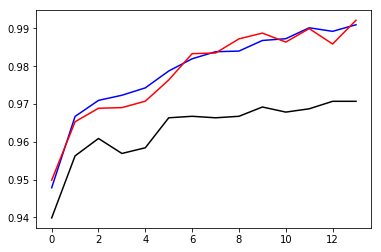

In [27]:
plt.plot(train_accuracy, 'b-', val_accuracy, 'r-', test_accuracy, 'k-')
plt.show()

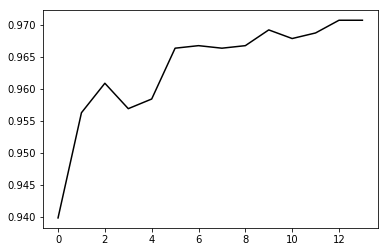

In [28]:
plt.plot(test_accuracy,'k-')
plt.show()

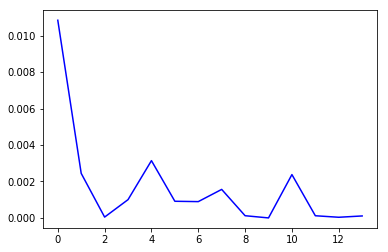

In [29]:
plt.plot(cost_curr, 'b-')
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=y_predicted_test)

array([[1219,    0,    6,    3,    1,    4,    6,    1,    4,    5],
       [   0, 1351,    9,    4,    4,    1,    1,    5,    1,    2],
       [   1,    4, 1216,    6,    4,    1,    2,    5,    6,    1],
       [   0,    0,   11, 1281,    0,   10,    0,   10,    2,    7],
       [   0,    0,    0,    0, 1193,    1,    9,    4,    2,   10],
       [   2,    0,    1,   10,    0, 1107,    6,    4,    2,    5],
       [   3,    0,    3,    0,    0,    3, 1237,    0,    2,    0],
       [   1,    5,   15,    6,    0,    0,    0, 1269,    0,    5],
       [   1,    7,   12,   23,    5,   11,    9,    4, 1150,    4],
       [   2,    1,    0,    6,   16,    5,    0,   15,    2, 1229]])

In [32]:
indices = np.where(np.logical_and(y_predicted_test == 3, y_test.squeeze() == 4))[0]
for i in indices:
    plt.figure(figsize=(0.50,0.50))
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
    plt.show()

In [33]:
import pandas as pd

# Load actual test data
dataframe = genfromtxt('test.csv', delimiter=',', skip_header=True)

y_true_test, X_true_test = dataframe[:,0], dataframe[:, :]
y_true_test = y_true_test.reshape([-1,1])

# Normalize the data
X_true_test -= 127
X_true_test /= 127

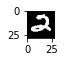

[-1.]


In [34]:
# print(X_true_test[0].reshape([28,28]))
plt.figure(figsize=(0.50,0.50))
plt.imshow(X_true_test[0].reshape([28,28]),cmap='gray')
plt.show()
print(y_true_test[0])

In [35]:
# Load the saved model
with tf.Session() as sess:
    model = tf.train.import_meta_graph('./MNIST_MODEL_FC.meta')
    model.restore(sess, tf.train.latest_checkpoint('./'))
    
    # Find final test accuracy
    y_final_predicted_test = np.argmax(output.eval(feed_dict={input_: X_true_test, 
                                                              labels: y_true_test, keep_prob:1.0}), 1)
    # Write predicted values to file in csv format
    out_index = np.array(list(range(1,len(y_final_predicted_test)+1)))
    data = pd.DataFrame({'Label': y_final_predicted_test})
    
    # Start index from 1
    data.index += 1
    data.to_csv('./predictions.csv', index_label=['ImageId'])

INFO:tensorflow:Restoring parameters from ./MNIST_MODEL_FC


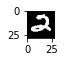

2


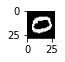

0


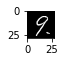

9


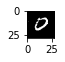

9


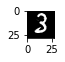

3


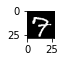

7


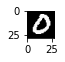

0


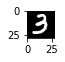

3


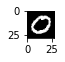

0


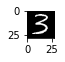

3


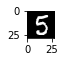

5


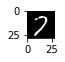

7


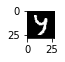

4


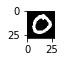

0


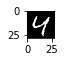

4


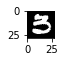

3


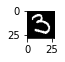

3


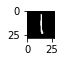

1


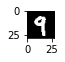

9


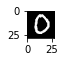

0


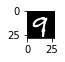

9


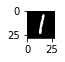

1


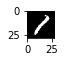

1


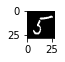

5


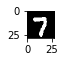

7


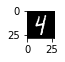

4


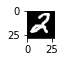

2


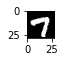

7


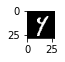

4


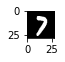

7


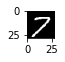

7


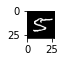

5


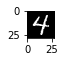

4


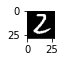

2


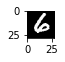

6


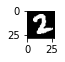

2


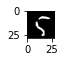

5


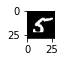

5


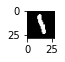

1


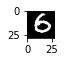

6


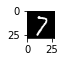

7


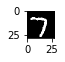

7


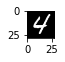

4


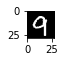

9


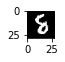

8


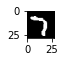

7


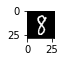

8


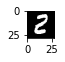

2


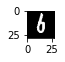

6


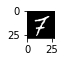

7


In [36]:
# print(X_true_test[0].reshape([28,28]))
for i in range(50):
    plt.figure(figsize=(0.50,0.50))
    plt.imshow(X_true_test[i].reshape([28,28]),cmap='gray')
    plt.show()
    print(y_final_predicted_test[i])